<a href="https://colab.research.google.com/github/boangri/neuraluniversity/blob/master/HW04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание к занятию №4 "Обработка текстов в нейронных сетях" 16.08.2020

Борис Грибовский <xinu@yandex.ru>

## LIGHT

In [ ]:
from google.colab import files # Для работы с файлами 
import numpy as np # Для работы с данными 
import pandas as pd # Для работы с таблицами
import matplotlib.pyplot as plt # Для вывода графиков
import os # Для работы с файлами
%matplotlib inline

%tensorflow_version 2.x 
from tensorflow.keras import utils # Для работы с категориальными данными
from tensorflow.keras.models import Sequential # Полносвязная модель
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation # Слои для сети
from tensorflow.keras.preprocessing.text import Tokenizer # Методы для работы с текстами и преобразования их в последовательности
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
import random

from sklearn.preprocessing import LabelEncoder # Метод кодирования тестовых лейблов
from sklearn.model_selection import train_test_split # Для разделения выборки на тестовую и обучающую
from google.colab import drive # Для работы с Google Drive
import time # Импортируем библиотеку time

In [ ]:
# Загружаем базу писателей
!wget https://xland.ru/uai/hw04/writers.zip
!unzip -q 'writers.zip' -d /content/texts 

--2020-08-27 18:40:50--  https://xland.ru/uai/hw04/writers.zip
Resolving xland.ru (xland.ru)... 198.211.125.59
Connecting to xland.ru (xland.ru)|198.211.125.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8960427 (8.5M) [application/zip]
Saving to: ‘writers.zip’

writers.zip         100%[===================>]   8.54M  --.-KB/s    in 0.1s    

2020-08-27 18:40:50 (62.9 MB/s) - ‘writers.zip’ saved [8960427/8960427]



In [ ]:
def readText(fileName): # Объявляем функции для чтения файла. На вход отправляем путь к файлу
  f = open(fileName, 'r')        # Задаем открытие нужного файла в режиме чтения
  text = f.read()                # Читаем текст
  text = text.replace("\n", " ") # Переносы строки переводим в пробелы
  
  return text                    # Возвращаем текст файла

className = ["О. Генри", "Стругацкие", "Булгаков", "Саймак", "Фрай", "Брэдберри"] # Объявляем интересующие нас классы
nClasses = len(className) # Считаем количество классов

In [ ]:
#Загружаем обучающие тексты

trainText = [] #Формируем обучающие тексты
testText = [] #Формируем тестовые тексты

#Формирование необходимо произвести следующим образом 
#Класс каждого i-ого эллемента в обучающей выборке должен соответствовать 
#классу каждого i-ого эллемента в тестовой выборке

for i in className: #Проходим по каждому классу
  for j in os.listdir('texts/'): #Проходим по каждому файлу в папке с текстами #
    if i in j: #Проверяем, содержит ли файл j в названии имя класса i
      
      if 'Обучающая' in j: #Если в имени найденного класса есть строка "Обучающая" 
        trainText.append(readText('texts/' + j)) #добавляем в обучающую выборку
        print(j, 'добавлен в обучающую выборку') #Выводим информацию
      if 'Тестовая' in j: #Если в имени найденного класса есть строка "Тестовая"
        testText.append(readText('texts/' + j)) #добавляем в обучающую выборку
        print(j, 'добавлен в тестовую выборку') #Выводим информацию
  print()

(О. Генри) Тестовая_20 вместе.txt добавлен в тестовую выборку
(О. Генри) Обучающая_50 вместе.txt добавлен в обучающую выборку

(Стругацкие) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Стругацкие) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Булгаков) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Булгаков) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Клиффорд_Саймак) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Клиффорд_Саймак) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Макс Фрай) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Макс Фрай) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Рэй Брэдберри) Тестовая_8 вместе.txt добавлен в тестовую выборку
(Рэй Брэдберри) Обучающая_22 вместе.txt добавлен в обучающую выборку



In [ ]:
cur_time = time.time() # Засекаем текущее время
maxWordsCount = 20000 # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов

# Воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
# num_words=maxWordsCount - определяем максимальное количество слов/индексов, учитываемое при обучении текстов
# filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' - избавляемся от ненужных символов
# lower=True - приводим слова к нижнему регистру
# split=' ' - разделяем слова по пробелу
# char_level=False - просим токенайзер не удалять однобуквенные слова
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='unknown', char_level=False)

tokenizer.fit_on_texts(trainText) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) # Вытаскиваем индексы слов для просмотра
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

Время обработки: 2.49c


In [ ]:
# Преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainText) # Обучающие тесты в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)  # Проверочные тесты в индексы

In [ ]:
# Формирование обучающей выборки по листу индексов слов
# (разделение на короткие векторы)
def getSetFromIndexes(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна
  xSample = [] # Объявляем переменную для векторов
  wordsLen = len(wordIndexes) # Считаем количество слов
  index = 0 # Задаем начальный индекс 

  while (index + xLen <= wordsLen):# Идём по всей длине вектора индексов
    xSample.append(wordIndexes[index:index+xLen]) # "Откусываем" векторы длины xLen
    index += step # Смещаеммся вперёд на step
    
  return xSample

In [ ]:
# Формирование обучающей и проверочной выборки
# Из двух листов индексов от двух классов
def createSetsMultiClasses(wordIndexes, xLen, step): # Функция принимает последовательность индексов, размер окна, шаг окна

  # Для каждого из 6 классов
  # Создаём обучающую/проверочную выборку из индексов
  nClasses = len(wordIndexes) # Задаем количество классов выборки
  classesXSamples = []        # Здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна (например, 6 по 1341*1000)"
  for wI in wordIndexes:      # Для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # Добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна" 

  # Формируем один общий xSamples
  xSamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*длину окна (например, 15779*1000)"
  ySamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*вектор длиной 6"
  
  for t in range(nClasses): # В диапазоне кол-ва классов(6)
    xT = classesXSamples[t] # Берем очередной текст вида "кол-во окон в тексте*длину окна"(например, 1341*1000)
    for i in range(len(xT)): # И каждое его окно
      xSamples.append(xT[i]) # Добавляем в общий список выборки
      ySamples.append(utils.to_categorical(t, nClasses)) # Добавляем соответствующий вектор класса

  xSamples = np.array(xSamples) # Переводим в массив numpy для подачи в нейронку
  ySamples = np.array(ySamples) # Переводим в массив numpy для подачи в нейронку

  
  return (xSamples, ySamples) #Функция возвращает выборку и соответствующие векторы классов

### Запустите нейронку c bag of words (01) при разных maxWordsCount
* 100
* 1000
* 10000
* 50000


In [ ]:
# Возвращает скомпиллированную модель для Bag of Words представления
def createBoWmodel(maxWordsCount, neurons=200, layers=1, activation='softmax', dropout=0.25):
  model = Sequential()
  model.add(Dense(neurons, input_dim=maxWordsCount, activation="relu"))
  model.add(Dropout(dropout))
  model.add(BatchNormalization())
  for _ in range(1, layers):
    model.add(Dense(neurons, activation="relu"))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
  model.add(Dense(6, activation=activation))
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
#Задаём базовые параметры
xLen = 1000 # Длина отрезка текста, по которой анализируем, в словах
step = 100 # Шаг разбиения исходного текста на обучающие векторы

209/209 [==============================] - 1s 4ms/step - loss: 0.4419 - accuracy: 0.8621


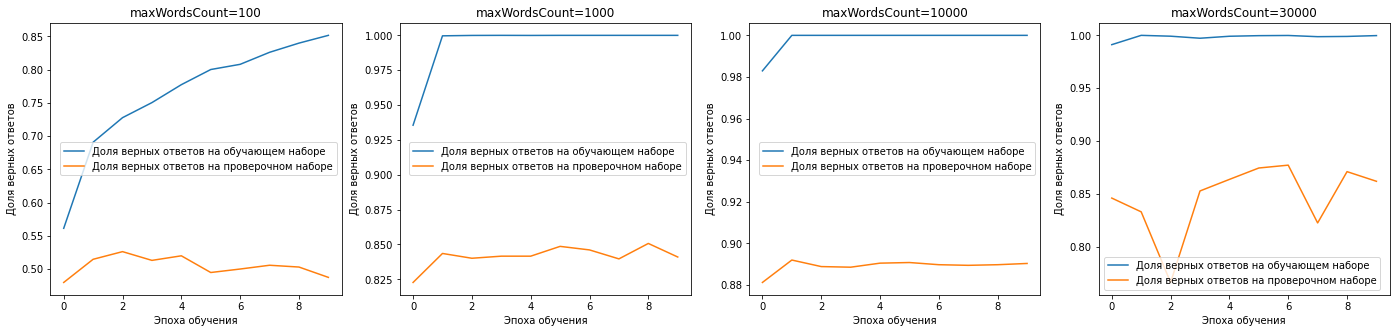

,Accuracy
100,0.487436
1000,0.841011
10000,0.890368
30000,0.862100


In [ ]:
# Пробуем разное maxWordsCount (50000 упорно крешит сессии. 40000 тоже.)
counts = (100, 1000, 10000, 30000)
results = np.zeros((len(counts),))
plt.figure(figsize=(24,5))
for i, maxWordsCount in enumerate(counts):
  tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='unknown', char_level=False)
  tokenizer.fit_on_texts(trainText)
  # Преобразовываем текст в последовательность индексов согласно частотному словарю
  trainWordIndexes = tokenizer.texts_to_sequences(trainText) # Обучающие тесты в индексы
  testWordIndexes = tokenizer.texts_to_sequences(testText)  # Проверочные тесты в индексы
  # Формируем обучающую и тестовую выборку
  xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) #извлекаем обучающую выборку
  xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    #извлекаем тестовую выборку
  # Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
  xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist()) #П одаем xTrain в виде списка, чтобы метод успешно сработал
  xTest01 = tokenizer.sequences_to_matrix(xTest.tolist()) # Подаем xTest в виде списка, чтобы метод успешно сработал
  # Обучаем сеть на выборке, сформированной по bag of words - xTrain01
  model01 = createBoWmodel(maxWordsCount)
  batch_size = 128 if maxWordsCount <= 10000 else 16 # To avoid session crash
  history = model01.fit(xTrain01, 
                        yTrain, 
                        epochs=10,
                        batch_size=batch_size,
                        verbose=0,
                        validation_data=(xTest01, yTest))
  score = model01.evaluate(xTest01, yTest)
  results[i] = score[1]
  plt.subplot(1, 4, i+1)
  plt.plot(history.history['accuracy'], 
          label='Доля верных ответов на обучающем наборе')
  plt.plot(history.history['val_accuracy'], 
          label='Доля верных ответов на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.title(f'maxWordsCount={maxWordsCount}')
  plt.legend()
plt.show()
df = pd.DataFrame(results, index=counts, columns=['Accuracy'])
df

**ВЫВОД** Запустить мешок слов размера 50000 не удалось, не хватало памяти даже при малых размерах батча. Точность растет с размером мешка, однако увеличение свыше 10000 уже не дает ощутимого выигрыша. Видимо нет смысла делать размер мешка больше 20000.

### Запустите нейронку c bag of words (01) при maxWordsCount = 20000 и разных архитектурах

* Поменяйте количество нейронов в слоях
* Поменяйте количество слоев
* Поменяйте активационные функции слоев


In [ ]:
maxWordsCount = 20000
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(trainText)
# Преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainText) # Обучающие тесты в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)  # Проверочные тесты в индексы
# Формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) #извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    #извлекаем тестовую выборку
# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist()) #П одаем xTrain в виде списка, чтобы метод успешно сработал
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist()) # Подаем xTest в виде списка, чтобы метод успешно сработал

209/209 [==============================] - 1s 4ms/step - loss: 0.3892 - accuracy: 0.8681


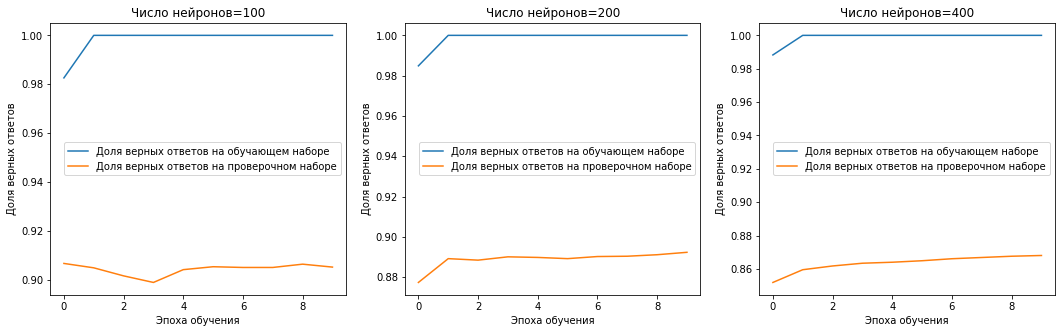

,Accuracy
100,0.905175
200,0.892312
400,0.868083


In [ ]:
# Пробуем разное количество нейронов
neurons = (100, 200, 400)
results = np.zeros((len(neurons),))
plt.figure(figsize=(18, 5))
for i, n in enumerate(neurons):
  model01 = createBoWmodel(maxWordsCount, neurons=n)
  history = model01.fit(xTrain01, 
                        yTrain, 
                        epochs=10,
                        batch_size=128,
                        verbose=0,
                        validation_data=(xTest01, yTest))
  score = model01.evaluate(xTest01, yTest)
  results[i] = score[1]
  plt.subplot(1, 3, i+1)
  plt.plot(history.history['accuracy'], 
          label='Доля верных ответов на обучающем наборе')
  plt.plot(history.history['val_accuracy'], 
          label='Доля верных ответов на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.title(f'Число нейронов={n}')
  plt.legend()
plt.show()

df = pd.DataFrame(results, index=neurons, columns=['Accuracy'])
df

**ВЫВОД** На данном примере не удалось выявить заметного влияния числа нейронов в последующих слоях. Поиски с помощью керас-тюнера показали что не сильно выраженный оптимум находится в районе 200-300 нейронов для второго слоя. Видимо вся "магия" происходит в первом слое, размер которого задается размером мешка слов. 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               4000200   
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 200)               800       
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1206      
Total params: 4,002,206
Trainable params: 4,001,806
Non-trainable params: 400
_________________________________________________________________
209/209 [==============================] - 1s 4ms/step - loss: 0.3300 - accuracy: 0.8859
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   

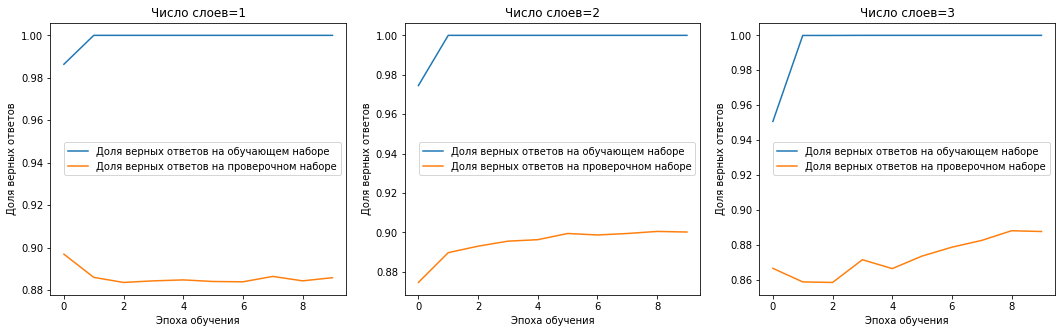

[0.88588095 0.90023929 0.88767576]


In [ ]:
# Пробуем разное количество слоев
layers = (1, 2, 3)
results = np.zeros((len(layers),))
maxWordsCount = 20000
plt.figure(figsize=(18, 5))
for i, n in enumerate(layers):
  model01 = createBoWmodel(maxWordsCount, layers=n)
  model01.summary()
  history = model01.fit(xTrain01, 
                        yTrain, 
                        epochs=10,
                        batch_size=128,
                        verbose=0,
                        validation_data=(xTest01, yTest))
  score = model01.evaluate(xTest01, yTest)
  results[i] = score[1]
  plt.subplot(1, 3, i+1)
  plt.plot(history.history['accuracy'], 
          label='Доля верных ответов на обучающем наборе')
  plt.plot(history.history['val_accuracy'], 
          label='Доля верных ответов на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.title(f'Число слоев={n}')
  plt.legend()
plt.show()
print(results)

### Запустите нейронку c Embbedding при maxWordsCount = 50000, поменяйте размер Embedding пространства
* 10
* 50
* 200


In [ ]:
# Задаём базовые параметры
xLen = 1000  # Длина отрезка текста, по которой анализируем, в словах
step = 100  # Шаг разбиения исходного текста на обучающие векторы
maxWordsCount = 50000
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(trainText)
# Преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainText) # Обучающие тесты в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)  # Проверочные тесты в индексы
# Формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step)  # извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    # извлекаем тестовую выборку

In [ ]:
def createEmbeddingModel(dim=20, xLen=1000, neurons=200, activation='softmax'):
  model = Sequential()
  model.add(Embedding(maxWordsCount, dim, input_length=xLen))
  model.add(SpatialDropout1D(0.2))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(neurons, activation="relu"))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())
  model.add(Dense(6, activation=activation))

  model.compile(optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
  return model

209/209 [==============================] - 3s 13ms/step - loss: 1.0265 - accuracy: 0.6567


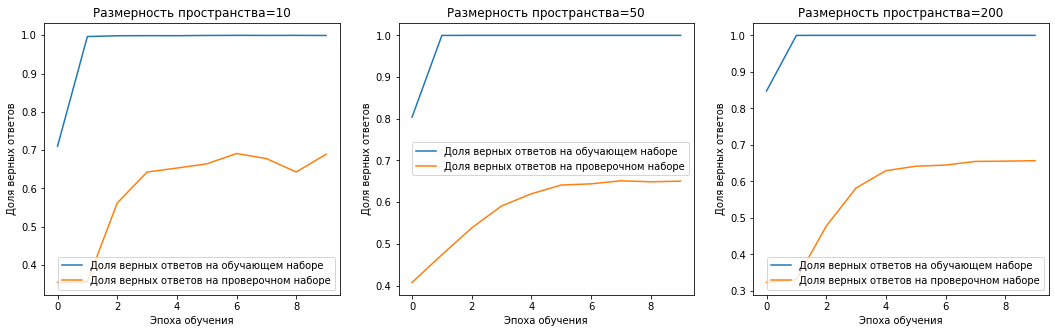

In [ ]:
# Пробуем разные размерности Embedding-пространства
dimensions = (10, 50, 200)
results = np.zeros((len(dimensions),))
plt.figure(figsize=(18,5))
for i, n in enumerate(dimensions):
  modelE = createEmbeddingModel(dim=n)
  history = modelE.fit(xTrain, 
                    yTrain, 
                    epochs=10,
                    batch_size=128,
                    verbose=0,
                    validation_data=(xTest, yTest))
  score = modelE.evaluate(xTest, yTest)
  results[i] = score[1]
  
  plt.subplot(1, 3, i+1)
  plt.plot(history.history['accuracy'], 
          label='Доля верных ответов на обучающем наборе')
  plt.plot(history.history['val_accuracy'], 
          label='Доля верных ответов на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.title(f'Размерность пространства={n}')
  plt.legend()
plt.show()

In [ ]:
df = pd.DataFrame(results, index=dimensions, columns=['Accuracy'])
df

,Accuracy
10,0.628777
50,0.672300
200,0.628627


**ВЫВОД** И тут не удалось выявить явно выраженной зависимости точности от размерности пространства векторов. Я обратил внимание, что в задаче, где анализировался только один признак (положительный или отрицательный отзыв) все "ключевые" слова выстраивались примерно в одну линию в пространстве векторов, независимо от размерности пространства. На лекции нам этот момент не объяснили. Непонятен алгоритм расположения слов в векторном пространстве. Могу лишь предположить, что размерность пространства нужно увеличивать с ростом словаря.

Мои предположения такие - значения векторов должны быть нормализованы (ст. отклонение 1) Чтобы сеть могла хорошо отличать слова по их векторным представлениям, нужно чтобы вектора заметно отличались друг от друга. Но в одном измерении можно разместить (грубо) порядка 5 хорошо различимых векторов. (Например -1, -0.5, 0., 0.5, .1) В N-мерном векторном пространстве мы получим емкость 5^N хорошо различимых векторов.
Значит 5^N должно быть равно размеру словаря. Другими словами N должно быть пропорционально логарифму размера словаря (по основанию 5-10) Поэтому 200 - явный перебор. 

## PRO

 ### Вариант 1

Добейтесь точности распознавания 97% и верно распознанных всех писателей с помощью любой нейронной сети без фильтрации данных. 


**Комментарий к задаче.**

Формулировка задачи _традиционно_ была нечеткой, было неясно, нужно ли было добиться 97% для val_accuracy для отдельных окон или речь шла о показателе в сводной таблице. Я делал задачу в первом понимании.

Я не воспринимал размер окна (xLen = 1000) как гиперпараметр. Ясно, что чем больше фрагмент текста, тем легче идентифицировать автора, и я понимал условие так, что размер фрагмента фиксирован и стоит задача улучшить точность.

Но после долгих безуспешных попыток подобрать гиперпараметры с помощью keras tuner (Наилучшая достигнутая точность на окне 1000 - 92.8%) стало понятно, что есть потолок в районе 93% и надо что-то менять более существенное.

Я пробовал применить [анализатор морфологии](https://pymorphy2.readthedocs.io/en/0.2/user/index.html) чтобы привести все слова к единой словоформе и таким образом уменьшить размер словаря. Эти попытки также не привели к успеху, возможно я что-то делал не так.

Но потом пришло сообщение от Рустема что ему удалось пробить 98% (а впоследствии сделать все 100%) так что стало понятно, что надо резко увеличить размер окна.

Итак, требуемый результат достигается путем увеличения окна до 10000 (например)

In [ ]:
cur_time = time.time() # Засекаем текущее время
maxWordsCount = 20000 # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов

# Отключаем фильтрацию данных
tokenizer = Tokenizer(num_words=maxWordsCount, filters='', lower=True, split=' ', oov_token='unknown', char_level=False)

tokenizer.fit_on_texts(trainText) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) # Вытаскиваем индексы слов для просмотра
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

Время обработки: 2.54c


In [ ]:
# Преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainText) # Обучающие тесты в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)  # Проверочные тесты в индексы

In [ ]:
#Задаём базовые параметры
xLen = 10000 # Длина отрезка текста, по которой анализируем, в словах
step = 100 # Шаг разбиения исходного текста на обучающие векторы

In [ ]:
cur_time = time.time() # Засекаем текущее время
#Формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) #извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    #извлекаем тестовую выборку
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)
#получили обучающий/тестовый набор, достаточный для запуска Embedding, но для Bag of Words нужно xTrain и xTest представить в виде векторов из 0 и 1
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

(17527, 10000)
(17527, 6)
(6278, 10000)
(6278, 6)
Время обработки: 19.87c


In [ ]:
cur_time = time.time() # Засекаем текущее время
# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist()) #П одаем xTrain в виде списка, чтобы метод успешно сработал
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist()) # Подаем xTest в виде списка, чтобы метод успешно сработал

print(xTrain01.shape)       # Размер обучающей выборки, сформированной по Bag of Words
print(xTrain01[0][0:100]) # Фрагмент набора слов в виде Bag of Words
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

(17527, 20000)
[0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
Время обработки: 62.88c


In [ ]:
# Параметры сети найдены с помощью keras tuner для окна 1000
random.seed(1)
np.random.seed(42)
tf.random.set_seed(11)

model01 = Sequential()

model01.add(Dense(224, input_dim=maxWordsCount, activation="relu"))
model01.add(BatchNormalization())
model01.add(Dropout(0.2))

model01.add(Dense(96, activation="relu"))
model01.add(BatchNormalization())
model01.add(Dropout(0.3))

model01.add(Dense(6, activation='sigmoid'))

In [ ]:
model01.compile(optimizer=Adam(lr=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model01.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 224)               4480224   
_________________________________________________________________
batch_normalization (BatchNo (None, 224)               896       
_________________________________________________________________
dropout (Dropout)            (None, 224)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 96)                21600     
_________________________________________________________________
batch_normalization_1 (Batch (None, 96)                384       
_________________________________________________________________
dropout_1 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 5

In [ ]:
# Создаем коллбэк для запоминания лучшей модели
model_save_path = 'best_model.h5'
checkpoint_callback = ModelCheckpoint(model_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

Epoch 1/20
137/137 [==============================] - ETA: 0s - loss: 0.4862 - accuracy: 0.9671
Epoch 00001: val_accuracy improved from -inf to 0.95078, saving model to best_model.h5
137/137 [==============================] - 2s 15ms/step - loss: 0.4862 - accuracy: 0.9671 - val_loss: 0.4314 - val_accuracy: 0.9508
Epoch 2/20
134/137 [============================>.] - ETA: 0s - loss: 0.1497 - accuracy: 0.9590
Epoch 00002: val_accuracy did not improve from 0.95078
137/137 [==============================] - 2s 12ms/step - loss: 0.1485 - accuracy: 0.9591 - val_loss: 0.3072 - val_accuracy: 0.9124
Epoch 3/20
136/137 [============================>.] - ETA: 0s - loss: 0.0789 - accuracy: 0.9657
Epoch 00003: val_accuracy improved from 0.95078 to 0.96225, saving model to best_model.h5
137/137 [==============================] - 2s 12ms/step - loss: 0.0789 - accuracy: 0.9656 - val_loss: 0.1786 - val_accuracy: 0.9622
Epoch 4/20
133/137 [============================>.] - ETA: 0s - loss: 0.0474 - accur

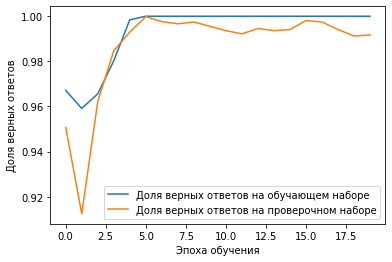

In [ ]:
#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model01.fit(xTrain01, 
                      yTrain, 
                      epochs=20,
                      batch_size=128,
                      callbacks=[checkpoint_callback],
                      validation_data=(xTest01, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
# Представляем тестовую выборку в удобных для распознавания размерах
def createTestMultiClasses(wordIndexes, xLen, step): #функция принимает последовательность индексов, размер окна, шаг окна

  #Для каждого из 6 классов
  #Создаём тестовую выборку из индексов
  nClasses = len(wordIndexes) #Задаем количество классов
  xTest6Classes01 = []               #Здесь будет список из всех классов, каждый размером "кол-во окон в тексте * 20000 (при maxWordsCount=20000)"
  xTest6Classes = []                 #Здесь будет список массивов, каждый размером "кол-во окон в тексте * длину окна"(6 по 420*1000)
  for wI in wordIndexes:                       #Для каждого тестового текста из последовательности индексов
    sample = (getSetFromIndexes(wI, xLen, step)) #Тестовая выборка размером "кол-во окон*длину окна"(например, 420*1000)
    xTest6Classes.append(sample)              # Добавляем в список
    xTest6Classes01.append(tokenizer.sequences_to_matrix(sample)) #Трансформируется в Bag of Words в виде "кол-во окон в тексте * 20000"
  xTest6Classes01 = np.array(xTest6Classes01)                     #И добавляется к нашему списку, 
  xTest6Classes = np.array(xTest6Classes)                     #И добавляется к нашему списку, 
  
  return xTest6Classes01, xTest6Classes  #функция вернёт тестовые данные: TestBag 6 классов на n*20000 и xTestEm 6 по n*1000

# Распознаём тестовую выборку и выводим результаты
def recognizeMultiClass(model, xTest, modelName):
  print("НЕЙРОНКА: ", modelName)
  print()
  
  totalSumRec = 0 # Сумма всех правильных ответов
  
  #Проходим по всем классам
  for i in range(nClasses):
    #Получаем результаты распознавания класса по блокам слов длины xLen
    currPred = model.predict(xTest[i])
    #Определяем номер распознанного класса для каждохо блока слов длины xLen
    currOut = np.argmax(currPred, axis=1)

    evVal = []
    for j in range(nClasses):
      evVal.append(len(currOut[currOut==j])/len(xTest[i]))

    totalSumRec += len(currOut[currOut==i])
    recognizedClass = np.argmax(evVal) #Определяем, какой класс в итоге за какой был распознан
    
    #Выводим результаты распознавания по текущему классу
    isRecognized = "Это НЕПРАВИЛЬНЫЙ ответ!"
    if (recognizedClass == i):
      isRecognized = "Это ПРАВИЛЬНЫЙ ответ!"
    str1 = 'Класс: ' + className[i] + " " * (11 - len(className[i])) + str(int(100*evVal[i])) + "% сеть отнесла к классу " + className[recognizedClass]
    print(str1, " " * (55-len(str1)), isRecognized, sep='')
  
  #Выводим средний процент распознавания по всем классам вместе
  print()
  sumCount = 0
  for i in range(nClasses):
    sumCount += len(xTest[i])
  print("Средний процент распознавания ", int(100*totalSumRec/sumCount), "%", sep='')

  print()
  
  return totalSumRec/sumCount

In [ ]:
xTest6Classes01, x2 = createTestMultiClasses(testWordIndexes, xLen, step) #Преобразование тестовой выборки

In [ ]:
#Проверяем точность нейронки обученной на bag of words
pred = recognizeMultiClass(model01, xTest6Classes01, "Тексты 01 + Dense")

НЕЙРОНКА:  Тексты 01 + Dense

Класс: О. Генри   100% сеть отнесла к классу О. Генри  Это ПРАВИЛЬНЫЙ ответ!
Класс: Стругацкие 100% сеть отнесла к классу СтругацкиеЭто ПРАВИЛЬНЫЙ ответ!
Класс: Булгаков   100% сеть отнесла к классу Булгаков  Это ПРАВИЛЬНЫЙ ответ!
Класс: Саймак     100% сеть отнесла к классу Саймак    Это ПРАВИЛЬНЫЙ ответ!
Класс: Фрай       97% сеть отнесла к классу Фрай       Это ПРАВИЛЬНЫЙ ответ!
Класс: Брэдберри  100% сеть отнесла к классу Брэдберри Это ПРАВИЛЬНЫЙ ответ!

Средний процент распознавания 99%



### Вариант 2

* Используйте разбиение текстов на фрагменты на базе обращения граждан в органы власти, как при распознавании писателей, например, размер блока - 20 слов, шаг - 1 слово.
* Сравните точность с базовым ноутбуком, проверьте 5 различных архитектур сети.
* Напишите функцию распознавания нужного обращения разделением его на фрагменты и распознаванием фрагментов.
* Попробуйте разные параметры фильтрации выборки. Добавьте какой-нибудь свой критерий для фильтрации.
* Запишите в конце ноутбука выводы о полученных исследованиях.


**Комментарий к задаче**
По сообщениям Рустема, разбиение по 20 слов с шагом 1 требует очень много оперативной памяти и практически невыполнимо. Я считаю, что надо либо использовать генератор данных (так как нам не нужно иметь все данные в оперативной памяти одновременно) - но я не умею создавать генераторы для подобных ситуаций. Вторая возможность - опробовать данный подход на другой задаче, про болезни ЖКТ. Там относительно мало сообщений (254) и маленький словарь (1981 слово) Так что проблем с памятью быть не должно. 

Я попытаюсь применить метод скользящего окна 20,1 в задаче диагностики болезней, вероятно там он лучше подходит.

То, что ниже - просто повторение того что было на занятии.

In [ ]:
!wget -q https://xland.ru/uai/hw04/clean_data.csv

In [ ]:
df = pd.read_csv('clean_data.csv') #загружаем данные в dataframe
df = df.iloc[:, :2] #извлечём тексты обращений и соответствующие им категории
df.head(10)    #посмотрим на содержимое

,text,category
0,Здравствуйте. Подскажите пожалуйста можно ли с...,Дороги и транспорт
1,Подскажите пожалуйста имеют ли право не платит...,ЖКХ
2,""" Спасибо Вам огромное за возобновление строит...",Строительство
3,Проблема одна и общая стала в городе. Спорт. у...,Спорт
4,Некоторое время назад для школьников и студент...,Дороги и транспорт
5,"Доброго времени суток! Надеюсь, мое сообщение ...",Дороги и транспорт
6,хочу предложить вот что у нас в городе потихон...,Дороги и транспорт
7,"Добрый вечер. Хотелось бы, чтобы обратили вним...",Дороги и транспорт
8,"Здравствуйте, больше 9 месяцев я и жильцы микр...",Благо­­устрой­­ство
9,На улице Кирова (это центр города!!!!) отсутст...,Дороги и транспорт


In [ ]:
for cl in df['category'].unique(): #Проходим по всем классам
  print('Количество записей класса ', cl, ': ', df[df.category == cl].shape[0])

Количество записей класса  Дороги и транспорт :  1411
Количество записей класса  ЖКХ :  2063
Количество записей класса  Строительство :  349
Количество записей класса  Спорт :  246
Количество записей класса  Благо­­устрой­­ство :  1686
Количество записей класса  Образование и наука :  290
Количество записей класса  Культура :  100
Количество записей класса  Демография :  20
Количество записей класса  Социальная сфера :  370
Количество записей класса  Другое :  208
Количество записей класса  Бизнес :  187
Количество записей класса  Здравоохранение :  368
Количество записей класса  Органы власти :  244
Количество записей класса  Экология :  180
Количество записей класса  Правопорядок :  172
Количество записей класса  Труд и занятость населения :  151
Количество записей класса  Борьба с коррупцией :  59
Количество записей класса  Промышленность :  13
Количество записей класса  Сельское хозяйство :  50
Количество записей класса  Земельные отношения :  80
Количество записей класса  Туризм :

In [ ]:
texts = df['text'].values #Извлекаем данные всех текстов из столбца text
classes = list(df['category'].values) #Извлекаем соответствующие им значения классов (лейблов) столбца text
maxWordsCount = 20000 #Зададим максимальное количество слов/индексов, учитываемое при обучении текстов

print(df['category'].unique()) #Выводим все уникальные значения классов
nClasses = df['category'].nunique()+1  #Задаём количество классов, обращаясь к столбцу category и оставляя уникальные значения
print(nClasses) #Посмотрим на количество классов

['Дороги и транспорт' 'ЖКХ' 'Строительство' 'Спорт'
 'Благо\xad\xadустрой\xad\xadство' 'Образование и наука' 'Культура'
 'Демография' 'Социальная сфера' 'Другое' 'Бизнес' 'Здравоохранение'
 'Органы власти' 'Экология' 'Правопорядок' 'Труд и занятость населения'
 'Борьба с коррупцией' 'Промышленность' 'Сельское хозяйство'
 'Земельные отношения' 'Туризм' nan]
22


In [ ]:
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(texts)
xAll = tokenizer.texts_to_matrix(texts) #Каждое слово из текста нашло свой индекс в векторе длиной maxWordsCount и отметилось в нем единичкой 
print(xAll.shape)  #Посмотрим на форму текстов
print(xAll[0, :20])#И отдельно на фрагмент начала вектора

(10059, 20000)
[0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [ ]:
print("Размер словаря", len(tokenizer.word_index.items()))

Размер словаря 80594


In [ ]:
#Преобразовываем категории в векторы
encoder = LabelEncoder() # Вызываем метод кодирования тестовых лейблов из библиотеки sklearn
encoder.fit(classes) # Подгружаем в него категории из нашей базы
classesEncoded = encoder.transform(classes) # Кодируем категории
print(encoder.classes_)
print(classesEncoded.shape)
print(classesEncoded[:10])

['nan' 'Бизнес' 'Благо\xad\xadустрой\xad\xadство' 'Борьба с коррупцией'
 'Демография' 'Дороги и транспорт' 'Другое' 'ЖКХ' 'Здравоохранение'
 'Земельные отношения' 'Культура' 'Образование и наука' 'Органы власти'
 'Правопорядок' 'Промышленность' 'Сельское хозяйство' 'Социальная сфера'
 'Спорт' 'Строительство' 'Труд и занятость населения' 'Туризм' 'Экология']
(10059,)
[ 5  7 18 17  5  5  5  5  2  5]


In [ ]:
yAll = utils.to_categorical(classesEncoded, nClasses) # И выводим каждый лейбл в виде вектора длиной 22, с 1кой в позиции соответствующего класса и нулями
print(yAll.shape) # Посмотрим на форму лейблов категорий
print(yAll[0]) # И отдельно на первую строку

(10059, 22)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
# разбиваем все данные на обучающую и тестовую выборки с помощью метода train_test_split из библиотеки sklearn
xTrain, xVal, yTrain, yVal = train_test_split(xAll, yAll, test_size=0.2)
print(xTrain.shape) #посмотрим на форму текстов из обучающей выборки
print(yTrain.shape) #и на форму соответсвующих им классов

(8047, 20000)
(8047, 22)


In [ ]:
# для Эмбэддинга представляем текст в виде последовательности индексов слов, каждый из которых затем преобразуем в многомерный вектор
Sequences = tokenizer.texts_to_sequences(texts) #разбиваем текст на последовательность индексов
npSequences = np.array(Sequences)                #переведём в массив numpy
xTrainE, xValE, yTrainE, yValE = train_test_split(npSequences, yAll, test_size=0.2)#сформируем новую форму выборки
print(xTrainE.shape) #посмотрим на форму текстов из обучающей выборки
print(yTrain.shape)  #и на форму соответствующих им классов

(8047,)
(8047, 22)


In [ ]:
model01 = Sequential()
model01.add(Dense(100, input_dim=maxWordsCount, activation="relu"))
model01.add(Dropout(0.4))
model01.add(Dense(100, activation='relu'))
model01.add(Dropout(0.4))
model01.add(Dense(100, activation='relu'))
model01.add(Dropout(0.4))
model01.add(Dense(nClasses, activation='softmax'))

model01.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [ ]:
model01.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               2000100   
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 22)                2

Epoch 1/20
63/63 [==============================] - 3s 49ms/step - loss: 2.4825 - accuracy: 0.2500 - val_loss: 1.9258 - val_accuracy: 0.4553
Epoch 2/20
63/63 [==============================] - 3s 41ms/step - loss: 1.8239 - accuracy: 0.4367 - val_loss: 1.7330 - val_accuracy: 0.4727
Epoch 3/20
63/63 [==============================] - 3s 41ms/step - loss: 1.4680 - accuracy: 0.5509 - val_loss: 1.6316 - val_accuracy: 0.5174
Epoch 4/20
63/63 [==============================] - 3s 41ms/step - loss: 1.1510 - accuracy: 0.6532 - val_loss: 1.6600 - val_accuracy: 0.5229
Epoch 5/20
63/63 [==============================] - 3s 41ms/step - loss: 0.8972 - accuracy: 0.7339 - val_loss: 1.7854 - val_accuracy: 0.5199
Epoch 6/20
63/63 [==============================] - 3s 41ms/step - loss: 0.7467 - accuracy: 0.7789 - val_loss: 1.8759 - val_accuracy: 0.5169
Epoch 7/20
63/63 [==============================] - 3s 40ms/step - loss: 0.6184 - accuracy: 0.8168 - val_loss: 2.0122 - val_accuracy: 0.5268
Epoch 8/20
63

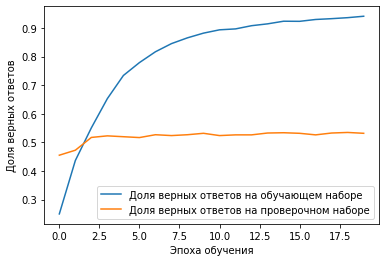

In [ ]:
history = model01.fit(xTrain, 
                    yTrain, 
                    epochs=20,
                    batch_size=128,
                    validation_data=(xVal, yVal))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

**Embedding + Dense**

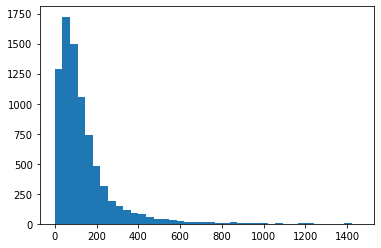

In [ ]:
lenXTrainE = [len(x) for x in xTrainE]
plt.hist(lenXTrainE, 40)
plt.show()

In [ ]:
maxlen = 400
xTrainE = pad_sequences(xTrainE, maxlen=maxlen) #Преобразуем входные векторы
xValE = pad_sequences(xValE, maxlen=maxlen) #Преобразуем входные векторы

In [ ]:
modelE = Sequential()

modelE.add(Embedding(maxWordsCount, 50, input_length=maxlen))
modelE.add(SpatialDropout1D(0.2))
modelE.add(Flatten())
modelE.add(BatchNormalization())
modelE.add(Dense(64, activation="relu"))
modelE.add(Dropout(0.2))
modelE.add(BatchNormalization())
modelE.add(Dense(nClasses, activation='softmax'))

modelE.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

Epoch 1/15
161/161 [==============================] - 8s 47ms/step - loss: 3.0849 - accuracy: 0.1366 - val_loss: 2.7267 - val_accuracy: 0.1973
Epoch 2/15
161/161 [==============================] - 7s 46ms/step - loss: 1.6861 - accuracy: 0.5096 - val_loss: 2.3941 - val_accuracy: 0.2197
Epoch 3/15
161/161 [==============================] - 8s 50ms/step - loss: 0.6884 - accuracy: 0.8283 - val_loss: 2.0797 - val_accuracy: 0.3658
Epoch 4/15
161/161 [==============================] - 8s 47ms/step - loss: 0.3010 - accuracy: 0.9415 - val_loss: 2.0570 - val_accuracy: 0.3743
Epoch 5/15
161/161 [==============================] - 7s 46ms/step - loss: 0.1552 - accuracy: 0.9746 - val_loss: 2.1767 - val_accuracy: 0.4036
Epoch 6/15
161/161 [==============================] - 7s 45ms/step - loss: 0.0963 - accuracy: 0.9867 - val_loss: 2.2295 - val_accuracy: 0.4220
Epoch 7/15
161/161 [==============================] - 7s 45ms/step - loss: 0.0706 - accuracy: 0.9888 - val_loss: 2.3180 - val_accuracy: 0.4095

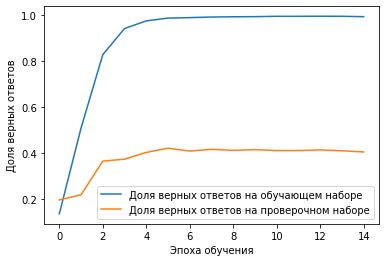

In [ ]:
history = modelE.fit(xTrainE, 
                    yTrainE, 
                    epochs=15,
                    batch_size=50,
                    validation_data=(xValE, yValE))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## ULTRA PRO

### Вариант 1

Выгрузите какой-нибудь из ваших диалогов любой соц.сети и напишите нейронную сеть для классификации собеседника по сообщению. Использование групповых чатов для обучения поощряется, но усложняет задачу. Если необходима конфиденциальность, датасет можно не предоставлять. 

Я взял БД MySQL форума PHPBB моего СНТ. Взяты посты 10 наиболее активных участников форума. Всего более 15000 постов, но они не совсем сбалансированы по авторам.

In [ ]:
# Скрипт делает дамп постов 10 наиболее активных пользователей в файл posts.csv 
# Скрипт надо запускать на сервере БД форума PHPBB

# import pymysql.cursors
# import csv

# # Connect to the database
# connection = pymysql.connect(host='localhost',
#                              user='phpbb3',
#                              password='*******',
#                              db='phpbb3',
#                              cursorclass=pymysql.cursors.DictCursor)
# try:

#     with open('posts.csv', mode='w') as csv_file:
#         fieldnames = ['poster_id', 'post_text']
#         writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
#         writer.writeheader()
#         with connection.cursor() as cursor:
#             sql = "SELECT `poster_id`, `post_text` FROM `phpbb3_posts` WHERE poster_id IN (3, 61, 1126, 937, 4, 31, 989, 700, 1, 947)"
#             cursor.execute(sql)
#             rows = cursor.fetchall()
#             count = 0
#             for row in rows:
#                 writer.writerow(row)
#                 count += 1
# finally:
#     connection.close()
#     print("rows:%d" % count)


In [ ]:
!wget https://xland.ru/uai/hw04/posts.csv

--2020-08-18 18:28:25--  https://xland.ru/uai/hw04/posts.csv
Resolving xland.ru (xland.ru)... 198.211.125.59
Connecting to xland.ru (xland.ru)|198.211.125.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17889181 (17M) [text/csv]
Saving to: ‘posts.csv’

posts.csv           100%[===================>]  17.06M   421KB/s    in 42s     

2020-08-18 18:29:08 (411 KB/s) - ‘posts.csv’ saved [17889181/17889181]



In [ ]:
df = pd.read_csv('posts.csv') # загружаем данные в dataframe
data = df.values # извлечём тексты обращений и соответствующие им категории

In [ ]:
df

,poster_id,post_text
0,4,Соседи!\r\n\r\nПо требованиям пожарной безопас...
1,3,А кто [i:1u1f2wcr]конкретно[/i:1u1f2wcr] требу...
2,4,"Боря!\r\n\r\nА ты разве не убедился, что пожар..."
3,31,"Борис, ты не прав!!!!! - все время хотел по Ел..."
4,4,[quote=&quot;Борис&quot;:bq9cro1y][quote=&quot...
...,...,...
15046,1126,[quote=&quot;aha&quot;:oael7lyd].... всех влад...
15047,1126,[quote=&quot;aha&quot;:1dkqisx1]Я не сильна в ...
15048,1126,"[quote=&quot;484&quot;:6xaxs5qe]Андрей, добрый..."
15049,1126,Какая наивность в наших реалиях: <!-- m --><a ...


In [ ]:
data.shape

(15051, 2)

In [ ]:
np.random.shuffle(data)

In [ ]:
data

array([[3,
        '[quote=&quot;Смирнов Андрей Юрьевич&quot;:f1vckpl1]\n\nТеперь вопрос к уважаемому Председателю СНТ.[/quote:f1vckpl1]\r\n\r\nОбращаюсь ко всем новичкам! Соблюдайте тематику форума!\r\nЗдесь задаются вопросы Лидеру. Имеются еще 2 форума - Газификация и &quot;вопрсы правлению&quot;. Там я отвечу на все вопросы. Советуемся тоже там. Не засоряйте диалог с Лидером!'],
       [1,
        '[quote=&quot;Bershik&quot;:lia0jmqa]Всем добрый день! <!-- s:) --><img src="{SMILIES_PATH}/smile.gif" alt=":)" title="Smile" /><!-- s:) -->\nВставляю свои 5 копеек \n<!-- m --><a class="postlink" href="http://foto.rambler.ru/users/snt-tvoidom/photos/?order=-uploaded">http://foto.rambler.ru/users/snt-tvoido ... =-uploaded</a><!-- m -->\n\nP1011905 кому занести тарелочки?\n\nЧтоб выложить фотки, пришлось зарегистрироваться на рамблере\n<!-- e --><a href="mailto:snt-tvoidom@rambler.ru">snt-tvoidom@rambler.ru</a><!-- e --> пароль Gerebec можно редактировать\n\nНадо бы придумать, что-то общее,

В постах широко используется цитирование друг друга, имеются вложенные цитаты. Это будет затруднять идентификацию автора. Для удаления цитат из постов написал такую функцию.

In [ ]:
# Функция для удаления цитирований (возможно вложенных) из постов
def cutQuotes(str):
  level = 0 # уровень вложенности цитирования. Увеличивается на 1 после тега [quote....], уменьшается после [/quote....]
  state = 0 # 1 - курсор внутри тега [quote....], 2 - внутри тега [/quote....], 0 - вне тегов.
  output = []

  while len(str) > 0:
    if state == 0:
      i = str.find('[quote')
      j = str.find('[/quote')
      if i < 0:
        if j < 0:
          if level == 0:
            output.append(str)
            break
          else:
            # print(level, state, str, output)
            raise Exception ('4')
        else: # j > 0
          str = str[j:]
          state = 2
      else:  # i > 0
        if j < 0:
          # print(level, state, str, output)
          raise Exception('5')
        else: # i > 0, j > 0
          if i > j:
            state = 2
            str = str[j:]
          else:
            if level == 0:
              output.append(str[:i])
            level += 1
            state = 1
            str = str[i:]
    elif state == 1:
      i = str.find(']')
      if i < 0:
        # print(level, state, str, output)
        raise Exception('Invalid format 1')
      else:
        str = str[i + 1:]
        state = 0
    else: # state == 2
      i = str.find(']')
      if i < 0:
        # print(level, state, str, output)
        raise Exception('Invalid format 2')
      else:
        str = str[i + 1:]
        level -= 1
        state = 0
  return ''.join(output)

In [ ]:
# Обрабатываем все посты - удаляем цитирование и сливаем все тексты в один список texts
# для последующего скармливания токенайзеру.
texts = []
uids = [] 
errCount = 0
for datum in data:
  try:
    datum[1] = cutQuotes(datum[1])
  except:
    errCount += 1
  texts.append(datum[1])
  uids.append(datum[0])
print(f"Ошибок при удалении цитирования - {errCount}")

Ошибок при удалении цитирования - 15


In [ ]:
len(texts)

15051

In [ ]:
df = pd.DataFrame(data, columns=['uid', 'text'])
df

,uid,text
0,3,\r\n\r\nОбращаюсь ко всем новичкам! Соблюдайте...
1,1,"\r\nАндрюш, ну ты герой!!! Пройти регистрацию ..."
2,989,\r\nПотому что:\r\n1. Это не предусмотрено зак...
3,4,\r\n\r\nЗаметано!\r\n\r\nАналогично и я - НЕ Б...
4,61,\r\nДобавлю от себя.\r\nМеня в школе учили: [i...
...,...,...
15046,31,Вспомнил!\r\n\r\nпервые слова &quot;доблестног...
15047,937,"\nЭтож бубльгум детка, сразу бы сказали что ну..."
15048,947,\r\n\r\nА по понятиям - это как?\r\n\r\nС паял...
15049,3,А разве я предлагал [i:whsyv6mi]ждать[/i:whsyv...


In [ ]:
texts = df['text'].values #Извлекаем данные всех текстов из столбца text
classes = list(df['uid'].values) #Извлекаем соответствующие им значения классов (лейблов) столбца text
maxWordsCount = 60000 #Зададим максимальное количество слов/индексов, учитываемое при обучении текстов
print(df['uid'].unique()) #Выводим все уникальные значения классов
nClasses = df['uid'].nunique()  #Задаём количество классов, обращаясь к столбцу category и оставляя уникальные значения
print(nClasses) #Посмотрим на количество классов

[3 1 989 4 61 947 937 700 1126 31]
10


In [ ]:
#Преобразовываем категории в векторы
encoder = LabelEncoder() # Вызываем метод кодирования тестовых лейблов из библиотеки sklearn
encoder.fit(classes) # Подгружаем в него категории из нашей базы
classesEncoded = encoder.transform(classes) # Кодируем категории
print(encoder.classes_)
print(classesEncoded.shape)
print(classesEncoded[:30])

[   1    3    4   31   61  700  937  947  989 1126]
(15051,)
[1 0 8 2 4 7 6 8 1 4 4 1 1 5 6 8 9 6 7 7 0 2 3 4 5 1 9 6 9 4]


In [ ]:
cur_time = time.time() # Засекаем текущее время
maxWordsCount = 20000 # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(texts) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) # Вытаскиваем индексы слов для просмотра
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

Время обработки: 2.0c


In [ ]:
len(items)

77965

In [ ]:
#Формируем матрицу индексов по принципу Bag of Words
xAll = tokenizer.texts_to_matrix(texts) #Каждое слово из текста нашло свой индекс в векторе длиной maxWordsCount и отметилось в нем единичкой 
print(xAll.shape)  #Посмотрим на форму текстов
print(xAll[0, :20])#И отдельно на фрагмент начала вектора

(15051, 20000)
[0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]


In [ ]:
yAll = utils.to_categorical(classesEncoded, nClasses) # И выводим каждый лейбл в виде вектора длиной 22, с 1кой в позиции соответствующего класса и нулями
print(yAll.shape) # Посмотрим на форму лейблов категорий
print(yAll[0]) # И отдельно на первую строку

(15051, 10)
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
# разбиваем все данные на обучающую и тестовую выборки с помощью метода train_test_split из библиотеки sklearn
xTrain, xVal, yTrain, yVal = train_test_split(xAll, yAll, test_size=0.2)
print(xTrain.shape) #посмотрим на форму текстов из обучающей выборки
print(yTrain.shape) #и на форму соответсвующих им классов

(12040, 20000)
(12040, 10)


In [ ]:
# для Эмбэддинга представляем текст в виде последовательности индексов слов, каждый из которых затем преобразуем в многомерный вектор
Sequences = tokenizer.texts_to_sequences(texts) #разбиваем текст на последовательность индексов
npSequences = np.array(Sequences)                #переведём в массив numpy
xTrainE, xValE, yTrainE, yValE = train_test_split(npSequences, yAll, test_size=0.2)#сформируем новую форму выборки
print(xTrainE.shape) #посмотрим на форму текстов из обучающей выборки
print(yTrain.shape)  #и на форму соответствующих им классов

(12040,)
(12040, 10)


Вариант с мешком слов

In [ ]:
model01 = Sequential()
model01.add(Dense(100, input_dim=maxWordsCount, activation="relu"))
model01.add(Dropout(0.4))

model01.add(Dense(100, activation='relu'))
model01.add(Dropout(0.4))

model01.add(Dense(100, activation='relu'))
model01.add(Dropout(0.4))

model01.add(Dense(nClasses, activation='softmax'))

model01.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

Epoch 1/20
95/95 [==============================] - 4s 45ms/step - loss: 2.0024 - accuracy: 0.2996 - val_loss: 1.7061 - val_accuracy: 0.4530
Epoch 2/20
95/95 [==============================] - 4s 41ms/step - loss: 1.4661 - accuracy: 0.5145 - val_loss: 1.3431 - val_accuracy: 0.5825
Epoch 3/20
95/95 [==============================] - 4s 42ms/step - loss: 1.0486 - accuracy: 0.6565 - val_loss: 1.2630 - val_accuracy: 0.6383
Epoch 4/20
95/95 [==============================] - 4s 41ms/step - loss: 0.7289 - accuracy: 0.7640 - val_loss: 1.2937 - val_accuracy: 0.6583
Epoch 5/20
95/95 [==============================] - 4s 41ms/step - loss: 0.5326 - accuracy: 0.8365 - val_loss: 1.3074 - val_accuracy: 0.6676
Epoch 6/20
95/95 [==============================] - 4s 40ms/step - loss: 0.3978 - accuracy: 0.8790 - val_loss: 1.4306 - val_accuracy: 0.6672
Epoch 7/20
95/95 [==============================] - 4s 41ms/step - loss: 0.3106 - accuracy: 0.9092 - val_loss: 1.5394 - val_accuracy: 0.6682
Epoch 8/20
95

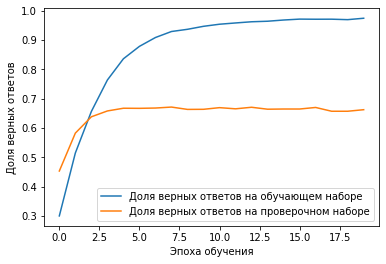

In [ ]:
history = model01.fit(xTrain, 
                    yTrain, 
                    epochs=20,
                    batch_size=128,
                    validation_data=(xVal, yVal))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Вариант Embedding

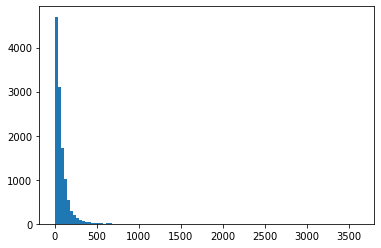

In [ ]:
# Построим гистограмму длин постов чтобы определиться с размером maxlen
lenXTrainE = [len(x) for x in xTrainE]
plt.hist(lenXTrainE, 100)
plt.show()

In [ ]:
maxlen = 400
# Дополняем короткие посты до длины maxlen
xTrainE = pad_sequences(xTrainE, maxlen=maxlen) 
xValE = pad_sequences(xValE, maxlen=maxlen) 

In [ ]:
# Как работает заполнение
xTrainE[1]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [ ]:
modelE = Sequential()
modelE.add(Embedding(maxWordsCount, 10, input_length=maxlen))
modelE.add(SpatialDropout1D(0.2))
modelE.add(Flatten())
modelE.add(BatchNormalization())
modelE.add(Dense(64, activation="relu"))
modelE.add(Dropout(0.2))
modelE.add(BatchNormalization())
modelE.add(Dense(nClasses, activation='softmax'))

modelE.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

Epoch 1/15
241/241 [==============================] - 3s 14ms/step - loss: 2.3207 - accuracy: 0.2297 - val_loss: 2.1204 - val_accuracy: 0.3119
Epoch 2/15
241/241 [==============================] - 3s 13ms/step - loss: 1.7030 - accuracy: 0.4321 - val_loss: 1.7817 - val_accuracy: 0.4208
Epoch 3/15
241/241 [==============================] - 3s 13ms/step - loss: 1.1283 - accuracy: 0.6270 - val_loss: 1.6647 - val_accuracy: 0.4494
Epoch 4/15
241/241 [==============================] - 3s 13ms/step - loss: 0.8396 - accuracy: 0.7306 - val_loss: 1.7155 - val_accuracy: 0.4610
Epoch 5/15
241/241 [==============================] - 3s 13ms/step - loss: 0.6274 - accuracy: 0.8019 - val_loss: 1.8107 - val_accuracy: 0.4507
Epoch 6/15
241/241 [==============================] - 3s 13ms/step - loss: 0.4945 - accuracy: 0.8437 - val_loss: 2.0538 - val_accuracy: 0.4537
Epoch 7/15
241/241 [==============================] - 3s 13ms/step - loss: 0.4141 - accuracy: 0.8694 - val_loss: 2.2479 - val_accuracy: 0.4244

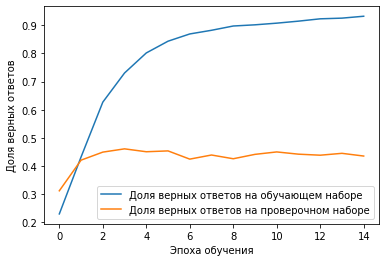

In [ ]:
history = modelE.fit(xTrainE, 
                    yTrainE, 
                    epochs=15,
                    batch_size=50,
                    validation_data=(xValE, yValE))


plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

**Итоги**

Подготовка данных - наиболее сложный и трудоемкий этап работы.
Удалось достичь точности распознания автора поста около 67% на "мешке слов" и 45% на эмбеддинге. Это немного, но существенно выше выбора наугад (10%). Я не стал подбирать гиперпараметры, поскольку порог точности не был задан. Для повышения точности можно использовать учет морфологии (приведение слов в нормальную форму, сокращение словаря) или методику "скользящего окна". 

### Вариант 2

Напишите нейронную сеть на базе болезней и добейтесь хорошей точности.


In [ ]:
!wget https://xland.ru/uai/hw04/diseases.zip

--2020-08-19 09:46:56--  https://xland.ru/uai/hw04/diseases.zip
Resolving xland.ru (xland.ru)... 198.211.125.59
Connecting to xland.ru (xland.ru)|198.211.125.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32902 (32K) [application/zip]
Saving to: ‘diseases.zip’

diseases.zip        100%[===================>]  32.13K  --.-KB/s    in 0s      

2020-08-19 09:46:57 (235 MB/s) - ‘diseases.zip’ saved [32902/32902]



In [ ]:
!unzip diseases

Archive:  diseases.zip
   creating: diseases/
  inflating: diseases/Аппендицит.txt  
  inflating: diseases/Гастрит.txt  
  inflating: diseases/Гепатит.txt  
  inflating: diseases/Дуоденит.txt  
  inflating: diseases/Колит.txt  
  inflating: diseases/Панкреатит.txt  
  inflating: diseases/Холицестит.txt  
  inflating: diseases/Эзофагит.txt  
  inflating: diseases/Энтерит.txt  
  inflating: diseases/Язва.txt   


In [ ]:
diseases = []
for i in os.listdir('diseases'):
  diseases.append(i[:-4])
diseases

['Энтерит',
 'Колит',
 'Гепатит',
 'Гастрит',
 'Аппендицит',
 'Холицестит',
 'Язва',
 'Панкреатит',
 'Эзофагит',
 'Дуоденит']

In [ ]:
# эта функция берет содержимое указанного файла и разбивает его на фрагменты.
# В качестве разделителя фрагментов используется пустая строка. 
def splitFile(fileName): # Объявляем функции для чтения файла. На вход отправляем путь к файлу
  f = open(fileName, 'r')        # Задаем открытие нужного файла в режиме чтения
  text = f.read()                # Читаем текст
  text = text.replace("\n\n", "$") # Пустые строки помечаем как разделители фрагментов
  text = text.replace("\n", " ") # Переводы строк заменяем на пробелы
  return text.split('$')                    # Возвращаем список фрагментов

def readText(fileName): # Объявляем функции для чтения файла. На вход отправляем путь к файлу
  f = open(fileName, 'r')        # Задаем открытие нужного файла в режиме чтения
  text = f.read()                # Читаем текст
  text = text.replace("\n", " ") # Переносы строки переводим в пробелы
  return text  

In [ ]:
# Извлекаем данные из файлов в 2 списка
data = [] # категория + текст
texts = [] # только тексты
for i, name in enumerate(diseases):
  fname = f'diseases/{name}.txt'
  print(i, fname)
  texts.append(readText(fname))
  symptoms = splitFile(fname)
  for symptom in symptoms:
    if len(symptom) > 0:
      data.append([i, symptom])
len(data)
nClasses = len(diseases)

0 diseases/Энтерит.txt
1 diseases/Колит.txt
2 diseases/Гепатит.txt
3 diseases/Гастрит.txt
4 diseases/Аппендицит.txt
5 diseases/Холицестит.txt
6 diseases/Язва.txt
7 diseases/Панкреатит.txt
8 diseases/Эзофагит.txt
9 diseases/Дуоденит.txt


In [ ]:
maxWordsCount = 2000 # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(texts) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) # Вытаскиваем индексы слов для просмотра

In [ ]:
print("Размер словаря", len(tokenizer.word_index.items()))

Размер словаря 1981


In [ ]:
# Готовим данные для разбиения на тренировочную и тестовую выборки 
classes = []
texts = []
for item in data:
  classes.append(item[0])
  texts.append(item[1])
xAll = tokenizer.texts_to_matrix(texts)
yAll = utils.to_categorical(classes, nClasses)

In [ ]:
# разбиваем данные на 2 выборки
xTrain, xVal, yTrain, yVal = train_test_split(xAll, yAll, test_size=0.2)

In [ ]:
xVal.shape

(51, 2000)

In [ ]:
yVal.shape

(51, 10)

In [ ]:
xTrain.shape

(203, 2000)

In [ ]:
xVal[3][:130]

array([0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
import random
import tensorflow.random

Подберем гиперпараметры с помощью keras tuner

In [ ]:
# установим его
!git clone https://github.com/keras-team/keras-tuner.git

Cloning into 'keras-tuner'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 6603 (delta 0), reused 0 (delta 0), pack-reused 6596
Receiving objects: 100% (6603/6603), 2.04 MiB | 11.81 MiB/s, done.
Resolving deltas: 100% (4623/4623), done.


In [ ]:
%cd keras-tuner
!pip install .
%cd /content


/content/keras-tuner
Processing /content/keras-tuner
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2rc1.dev0-cp36-none-any.whl size=91703 sha256=2efefdaf33d7d1b63a91bd21380529b14bffeda4e65525ae4a4b496bd1cea2dd
  Stored in directory: /root/.cache/pip/wheels/fa/4e/d0/ed331a3363786e8a74848aa0589674f502cbb3f0321cdba844
Successfully built keras-tuner
  Found existing installation: keras-tuner 1.0.2rc1.dev0
    Uninstalling keras-tuner-1.0.2rc1.dev0:
      Successfully uninstalled keras-tuner-1.0.2rc1.dev0


/content


In [ ]:
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization

In [ ]:
# С помощью этой функции тюнер будет создавать модели
def build_model(hp):
    random.seed(1)
    np.random.seed(42)
    tensorflow.random.set_seed(1)
    model = Sequential()
    activation_choice = hp.Choice('activation', values=['softmax', 'sigmoid'])  
    model.add(Dense(units=hp.Int('units_input',    # Полносвязный слой с разным количеством нейронов
                                   min_value=64,    # минимальное количество нейронов - 32
                                   max_value=512,   # максимальное количество - 256
                                   step=64),
                    input_dim=maxWordsCount,
                    activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(units=hp.Int('units_hidden',        
                                   min_value=32,   
                                   max_value=128,   
                                   step=32),
                    activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(10, activation=activation_choice))
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam','rmsprop']),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [ ]:
# Создаем экземпляр тюнера
tuner = RandomSearch(
    build_model,                 # функция создания модели
    objective='val_accuracy',    # метрика, которую нужно оптимизировать - 
                                 # доля правильных ответов на проверочном наборе данных
    max_trials=150,               # максимальное количество запусков обучения 
    directory='test_directory'   # каталог, куда сохраняются обученные сети  
    )

INFO:tensorflow:Reloading Oracle from existing project test_directory/untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from test_directory/untitled_project/tuner0.json


In [ ]:
# Пространство подбираемых гиперпараметров
tuner.search_space_summary()

Search space summary
Default search space size: 4
activation (Choice)
{'default': 'softmax', 'conditions': [], 'values': ['softmax', 'sigmoid'], 'ordered': False}
units_input (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 64, 'sampling': None}
units_hidden (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop'], 'ordered': False}


In [ ]:
%%time
# Запускаем подбор гиперпараметров
tuner.search(xTrain,                   # Данные для обучения
             yTrain,                   # Правильные ответы
             batch_size=10,            # Размер мини-выборки
             epochs=30,                # Количество эпох обучения 
             validation_data=(xVal, yVal))

Trial 6 Complete [00h 00m 08s]
val_accuracy: 0.5686274766921997

Best val_accuracy So Far: 0.6470588445663452
Total elapsed time: 00h 00m 37s
INFO:tensorflow:Oracle triggered exit
CPU times: user 47.7 s, sys: 2.95 s, total: 50.6 s
Wall time: 37.4 s


In [ ]:
tuner.results_summary()

Results summary
Results in test_directory/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
activation: sigmoid
units_input: 384
units_hidden: 96
optimizer: rmsprop
Score: 0.6470588445663452
Trial summary
Hyperparameters:
activation: sigmoid
units_input: 512
units_hidden: 64
optimizer: adam
Score: 0.6274510025978088
Trial summary
Hyperparameters:
activation: sigmoid
units_input: 384
units_hidden: 32
optimizer: rmsprop
Score: 0.6078431606292725
Trial summary
Hyperparameters:
activation: softmax
units_input: 512
units_hidden: 64
optimizer: rmsprop
Score: 0.6078431606292725
Trial summary
Hyperparameters:
activation: sigmoid
units_input: 384
units_hidden: 96
optimizer: adam
Score: 0.6078431606292725
Trial summary
Hyperparameters:
activation: softmax
units_input: 320
units_hidden: 32
optimizer: rmsprop
Score: 0.6078431606292725
Trial summary
Hyperparameters:
activation: sigmoid
units_input: 448
units_hidden: 96
optimizer: 

In [ ]:
models = tuner.get_best_models(num_models=3)

In [ ]:
for model in models:
  model.summary()
  model.evaluate(xVal, yVal)
  print()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 384)               768384    
_________________________________________________________________
batch_normalization (BatchNo (None, 384)               1536      
_________________________________________________________________
dropout (Dropout)            (None, 384)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 96)                36960     
_________________________________________________________________
batch_normalization_1 (Batch (None, 96)                384       
_________________________________________________________________
dropout_1 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                9

**ВЫВОД** 

keras-tuner нашел модель, дающую точность 64.71% на "мешке слов"

Попробуем применить метод "скользящего окна" для улучшения точности 

In [ ]:
# Извлекаем данные из файлов в 2 списка
data = [] # категория + текст
texts = [] # только тексты
for i, name in enumerate(diseases):
  fname = f'diseases/{name}.txt'
  print(i, fname)
  texts.append(readText(fname))
  symptoms = splitFile(fname)
  for symptom in symptoms:
    if len(symptom) > 0:
      data.append([i, symptom])
len(data)
nClasses = len(diseases)

0 diseases/Энтерит.txt
1 diseases/Колит.txt
2 diseases/Гепатит.txt
3 diseases/Гастрит.txt
4 diseases/Аппендицит.txt
5 diseases/Холицестит.txt
6 diseases/Язва.txt
7 diseases/Панкреатит.txt
8 diseases/Эзофагит.txt
9 diseases/Дуоденит.txt


In [ ]:
# Перемешаем данные 
random.shuffle(data)

In [ ]:
# Сколько у нас образцов?
len(data)

254

In [ ]:
# Разделим данные на тренировочные и тестовые
trainTexts = []
trainClasses = []
testTexts = []
testClasses = []
for i, item in enumerate(data):
    if i < 0.8*len(data):
        trainClasses.append(item[0])
        trainTexts.append(item[1])
    else:
        testClasses.append(item[0])
        testTexts.append(item[1])

In [ ]:
maxWordsCount = 2000 # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(trainTexts) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) # Вытаскиваем индексы слов для просмотра

In [ ]:
# Преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainTexts) # Обучающие тесты в индексы
testWordIndexes = tokenizer.texts_to_sequences(testTexts)  # Проверочные тесты в индексы

print("Взглянем на фрагмент обучающего текста:")
print("В виде оригинального текста:              ", trainTexts[1][:87])
print("Он же в виде последовательности индексов: ", trainWordIndexes[1][:20], '\n')

Взглянем на фрагмент обучающего текста:
В виде оригинального текста:               быстрая утомляемость, снижение толерантности к физическим нагрузкам, нарушения сна, деп
Он же в виде последовательности индексов:  [165, 71, 23, 758, 25, 472, 759, 72, 166, 760, 761, 195, 144, 473, 59, 2, 37, 33] 



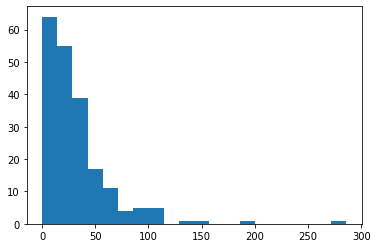

In [ ]:
# Посмотрим распределение по длине описания симптомов в тренировочной выборке
# 
len = [len(x) for x in trainWordIndexes]
plt.hist(len, 20)
plt.show()

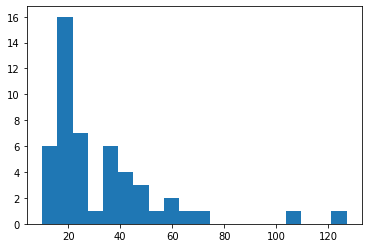

In [ ]:
# то же в тестовой выборке
# много коротких (меньше размера окна) 
len = [len(x) for x in testWordIndexes]
plt.hist(len, 20)
plt.show()

In [ ]:
#Задаём базовые параметры
xLen = 20 #Длина отрезка текста, по которой анализируем, в словах
step = 1 #Шаг разбиения исходного текста на обучающие векторы

In [ ]:
# Формирование обучающей выборки по листу индексов слов
# (разделение на короткие векторы)
def getSetFromIndexes(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна
  xSample = [] # Объявляем переменную для векторов
  wordsLen = len(wordIndexes) # Считаем количество слов
  index = 0 # Задаем начальный индекс 

  while (index + xLen <= wordsLen):# Идём по всей длине вектора индексов
    xSample.append(wordIndexes[index:index+xLen]) # "Откусываем" векторы длины xLen
    index += step # Смещаеммся вперёд на step
    
  return xSample

In [ ]:
# Пришлось слегка модифицировать функцию из лекции.
#
# Формирование обучающей и проверочной выборки
# Из двух листов индексов от двух классов
def createSetsMultiClasses2(wordIndexes, classes, xLen, step, nClasses): # Функция принимает последовательность индексов, размер окна, шаг окна
    xSamples = []
    ySamples = []
    for i, index in enumerate(wordIndexes):
        cl = classes[i]
        xs = getSetFromIndexes(index, xLen, step) # получили список окон из одного образца
        for x in xs:
            xSamples.append(x)
            ySamples.append(utils.to_categorical(cl, nClasses))
    return np.array(xSamples), np.array(ySamples) 

In [ ]:
print(len(trainWordIndexes))
print(len(testWordIndexes))

204
50


In [ ]:
cur_time = time.time() # Засекаем текущее время
#Формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses2(trainWordIndexes, trainClasses, xLen, step, nClasses) #извлекаем обучающую выборку
print(xTrain.shape)
print(yTrain.shape)
xTest, yTest = createSetsMultiClasses2(testWordIndexes, testClasses, xLen, step, nClasses)    #извлекаем тестовую выборку
print(xTest.shape)
print(yTest.shape)
#получили обучающий/тестовый набор, достаточный для запуска Embedding, но для Bag of Words нужно xTrain и xTest представить в виде векторов из 0 и 1
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

(3422, 20)
(3422, 10)
(752, 20)
(752, 10)
Время обработки: 0.06c


In [ ]:
xTrain[0]

array([755,   4,   2, 193,  83,   3, 141,  32,   9, 244,  46,  70, 321,
        10, 194,   7,   2, 756,   4,   2])

In [ ]:
# Проверим что данные сдвигаются на 1 позицию:
xTrain[1]

array([  4,   2, 193,  83,   3, 141,  32,   9, 244,  46,  70, 321,  10,
       194,   7,   2, 756,   4,   2,  11])

In [ ]:
className = diseases
className

['Энтерит',
 'Колит',
 'Гепатит',
 'Гастрит',
 'Аппендицит',
 'Холицестит',
 'Язва',
 'Панкреатит',
 'Эзофагит',
 'Дуоденит']

In [ ]:
print("Статистика по обучающим текстам:")

symbolsTrainText = 0 # Объявляем переменную для подсчета символов в обучающих текстах
wordsTrainText = 0 # Объявляем переменную для подсчета слов в обучающих текстах

for i in range(nClasses): # Проходим по всем классам
  print(className[i], " "*(10-len(className[i])), len(trainTexts[i]), "символов, ", len(trainWordIndexes[i]), "слов")
  symbolsTrainText += len(trainTexts[i]) # Считаем символы
  wordsTrainText += len(trainWordIndexes[i]) # Считаем слова 

print('----')
print("В сумме ", symbolsTrainText, " символов, ", wordsTrainText, " слов \n")
print()
print("Статистика по тестовым текстам:")

symbolsTestText = 0 # Объявляем переменную для подсчета символов в тестовых текстах
wordsTestText = 0 # Объявляем переменную для подсчета слов в тестовых текстах

for i in range(nClasses): #Проходим по всем классам
  print(className[i], ' '*(10-len(className[i])), len(testTexts[i]), "символов, ", len(testWordIndexes[i]), "слов")
  symbolsTestText += len(testTexts[i]) #Считаем символы
  wordsTestText += len(testWordIndexes[i]) #Считаем слова 
print('----')
print("В сумме ", symbolsTestText, " символов, ", wordsTestText, " слов")

Статистика по обучающим текстам:
Энтерит     208 символов,  32 слов
Колит       162 символов,  18 слов
Гепатит     160 символов,  22 слов
Гастрит     240 символов,  37 слов
Аппендицит  283 символов,  44 слов
Холицестит  264 символов,  35 слов
Язва        101 символов,  13 слов
Панкреатит  740 символов,  108 слов
Эзофагит    201 символов,  22 слов
Дуоденит    121 символов,  14 слов
----
В сумме  2480  символов,  345  слов 


Статистика по тестовым текстам:
Энтерит     308 символов,  35 слов
Колит       139 символов,  18 слов
Гепатит     182 символов,  31 слов
Гастрит     151 символов,  23 слов
Аппендицит  486 символов,  62 слов
Холицестит  419 символов,  59 слов
Язва        295 символов,  45 слов
Панкреатит  135 символов,  17 слов
Эзофагит    346 символов,  37 слов
Дуоденит    221 символов,  25 слов
----
В сумме  2682  символов,  352  слов


In [ ]:
cur_time = time.time() # Засекаем текущее время
# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist()) #П одаем xTrain в виде списка, чтобы метод успешно сработал
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist()) # Подаем xTest в виде списка, чтобы метод успешно сработал

print(xTrain01.shape)       # Размер обучающей выборки, сформированной по Bag of Words
print(xTrain01[0][0:100]) # Фрагмент набора слов в виде Bag of Words
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

(3422, 2000)
[0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Время обработки: 0.09c


In [ ]:
xTrain01[0]

array([0., 0., 1., ..., 0., 0., 0.])

In [ ]:
yTrain.shape

(3422, 10)

In [ ]:
#Создаём полносвязную сеть
model01 = Sequential()
model01.add(Dense(200, input_dim=maxWordsCount, activation="relu"))
model01.add(BatchNormalization())
model01.add(Dropout(0.5))

model01.add(Dense(nClasses, activation='sigmoid'))

model01.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


Epoch 1/15
27/27 [==============================] - 0s 11ms/step - loss: 1.7361 - accuracy: 0.6879 - val_loss: 2.2134 - val_accuracy: 0.3351
Epoch 2/15
27/27 [==============================] - 0s 6ms/step - loss: 1.3511 - accuracy: 0.9798 - val_loss: 2.1509 - val_accuracy: 0.4348
Epoch 3/15
27/27 [==============================] - 0s 6ms/step - loss: 1.1524 - accuracy: 0.9836 - val_loss: 2.0851 - val_accuracy: 0.4588
Epoch 4/15
27/27 [==============================] - 0s 6ms/step - loss: 0.9272 - accuracy: 0.9772 - val_loss: 2.0237 - val_accuracy: 0.4588
Epoch 5/15
27/27 [==============================] - 0s 6ms/step - loss: 0.6949 - accuracy: 0.9646 - val_loss: 1.9914 - val_accuracy: 0.4269
Epoch 6/15
27/27 [==============================] - 0s 6ms/step - loss: 0.4988 - accuracy: 0.9445 - val_loss: 1.9909 - val_accuracy: 0.4082
Epoch 7/15
27/27 [==============================] - 0s 6ms/step - loss: 0.3770 - accuracy: 0.9331 - val_loss: 2.0260 - val_accuracy: 0.4043
Epoch 8/15
27/27 [=

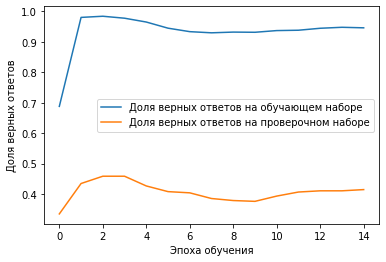

In [ ]:

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model01.fit(xTrain01, 
                      yTrain, 
                      epochs=15,
                      batch_size=128,
                      validation_data=(xTest01, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Результаты на отдельном окне ухудшились, но теперь можно попытаться выжать точность за счет "голосования"

**ВЫВОД**

Я рассчитывал воспользоваться функциями из задачи про писателей, но оказалось что они написаны для вырожденного случая когда число классов совпадает с числом тестовых образцов. Эти функции нуждаются в обобщении на более общий случай. К тому же выявилась еще одна проблема - "скользящее окно" пожалуй не годится для случая когда много коротких текстов (короче размера окна). Такие тексты вообще нельзя обработать.

В общем, мои предположения что "скользящее окно" хорошо подойдет для задачи диагностики болезней не оправдались.